# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

The goal of this sprint is to analyze reviews of movies and try to get a model to be able to predict whether they are positive or negative on the movie.  We will first analyze what the data looks like then from there use different models to calculate an F1 score on the data.  The objective is to obtain an F1 score higher than 0.85.  

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
print(df_reviews.head(10))

      tconst title_type                                      primary_title  \
0  tt0068152      movie                                                  $   
1  tt0068152      movie                                                  $   
2  tt0313150      short                                               '15'   
3  tt0313150      short                                               '15'   
4  tt0313150      short                                               '15'   
5  tt0313150      short                                               '15'   
6  tt0313150      short                                               '15'   
7  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
8  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
9  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   

                                      original_title  start_year end_year  \
0                                                  $        1971

## EDA

Let's check the number of movies and reviews over years.

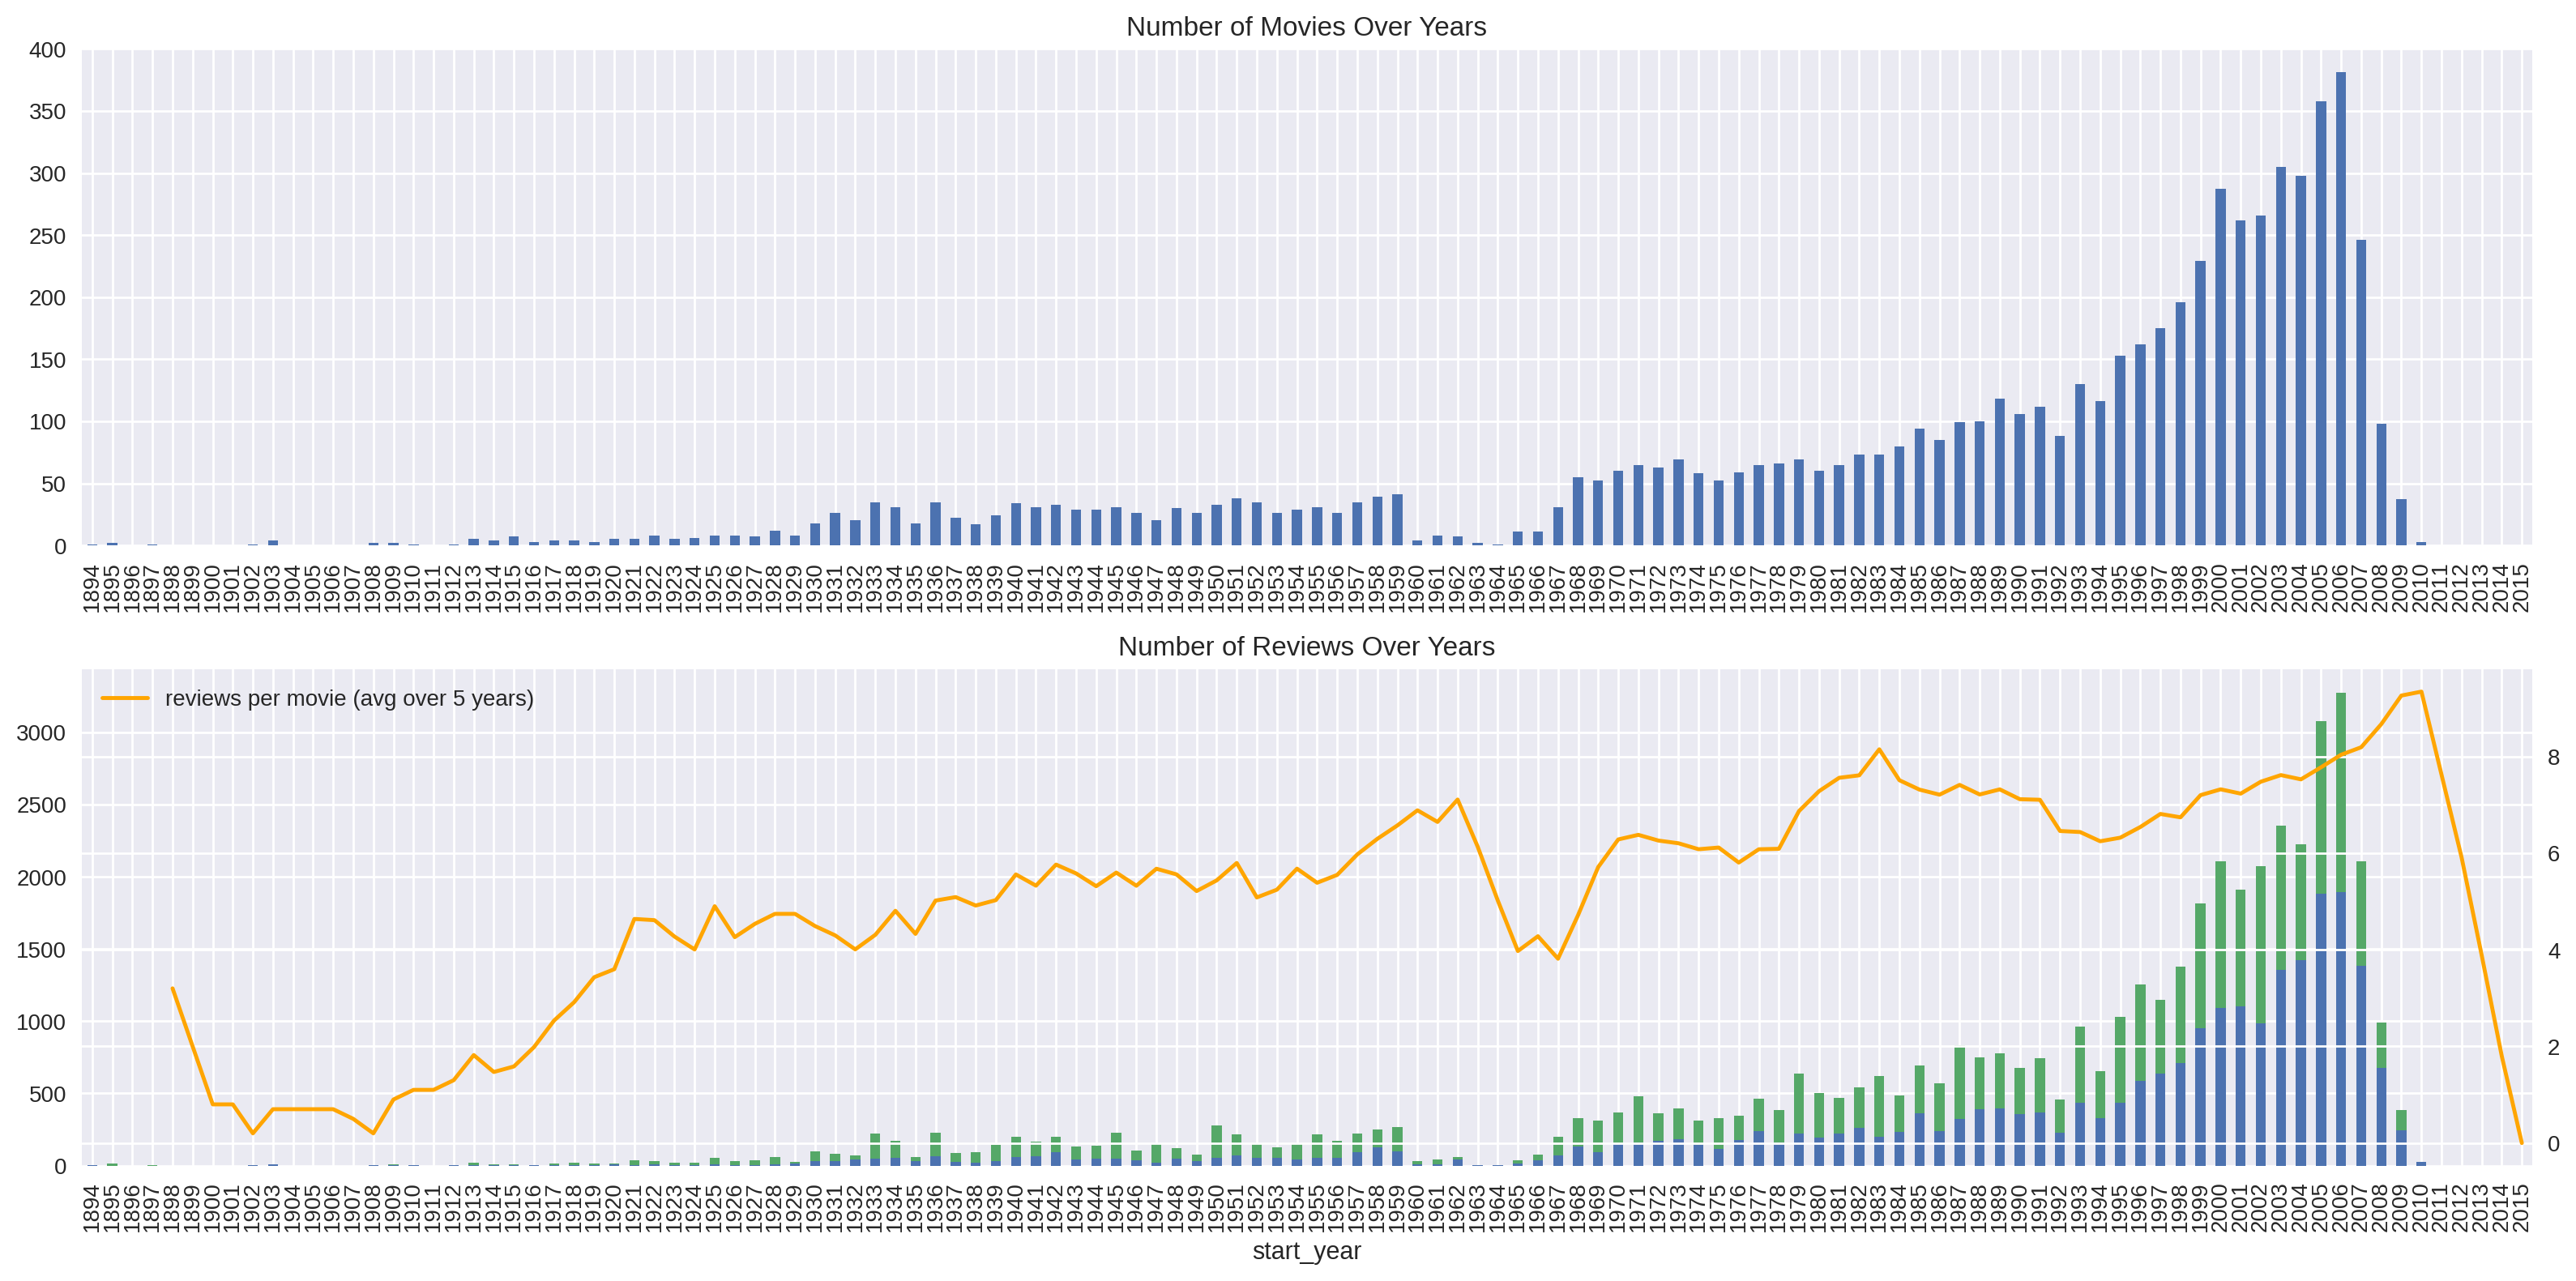

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2016))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2016))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2016))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

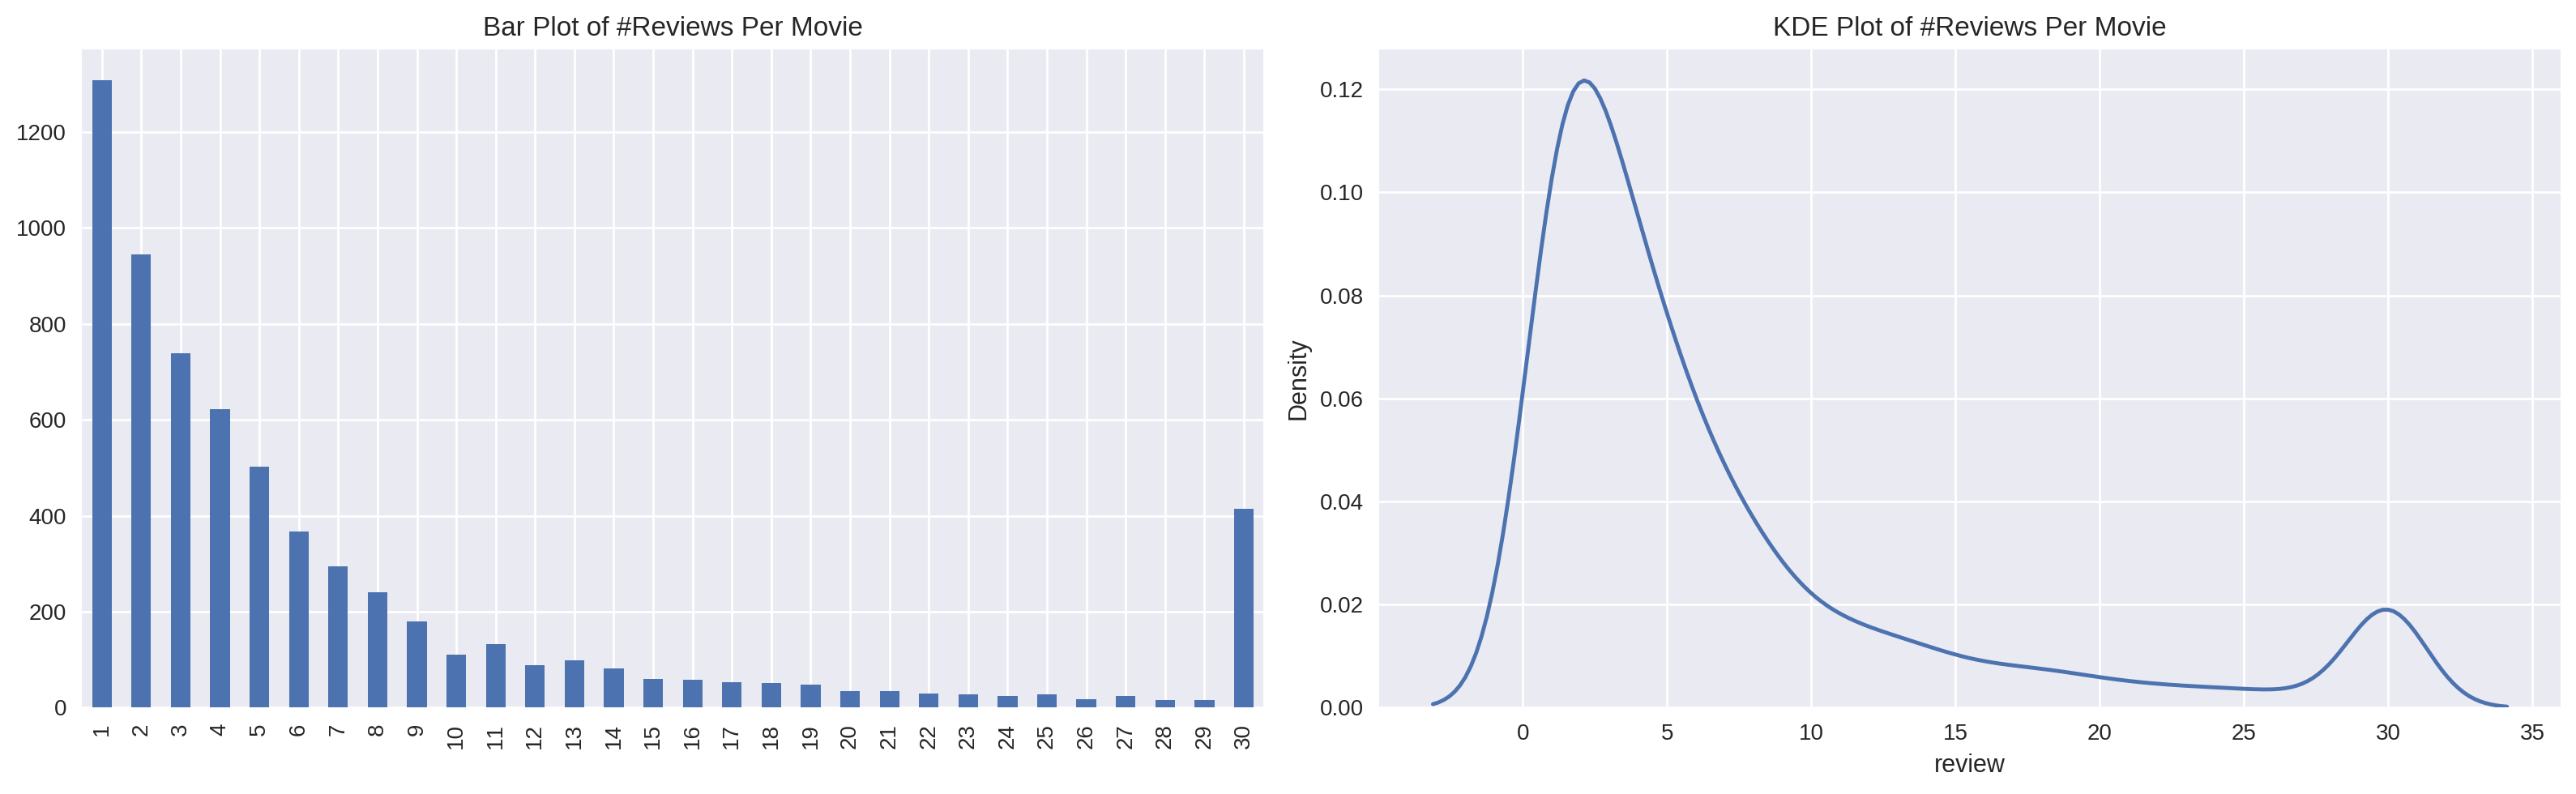

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

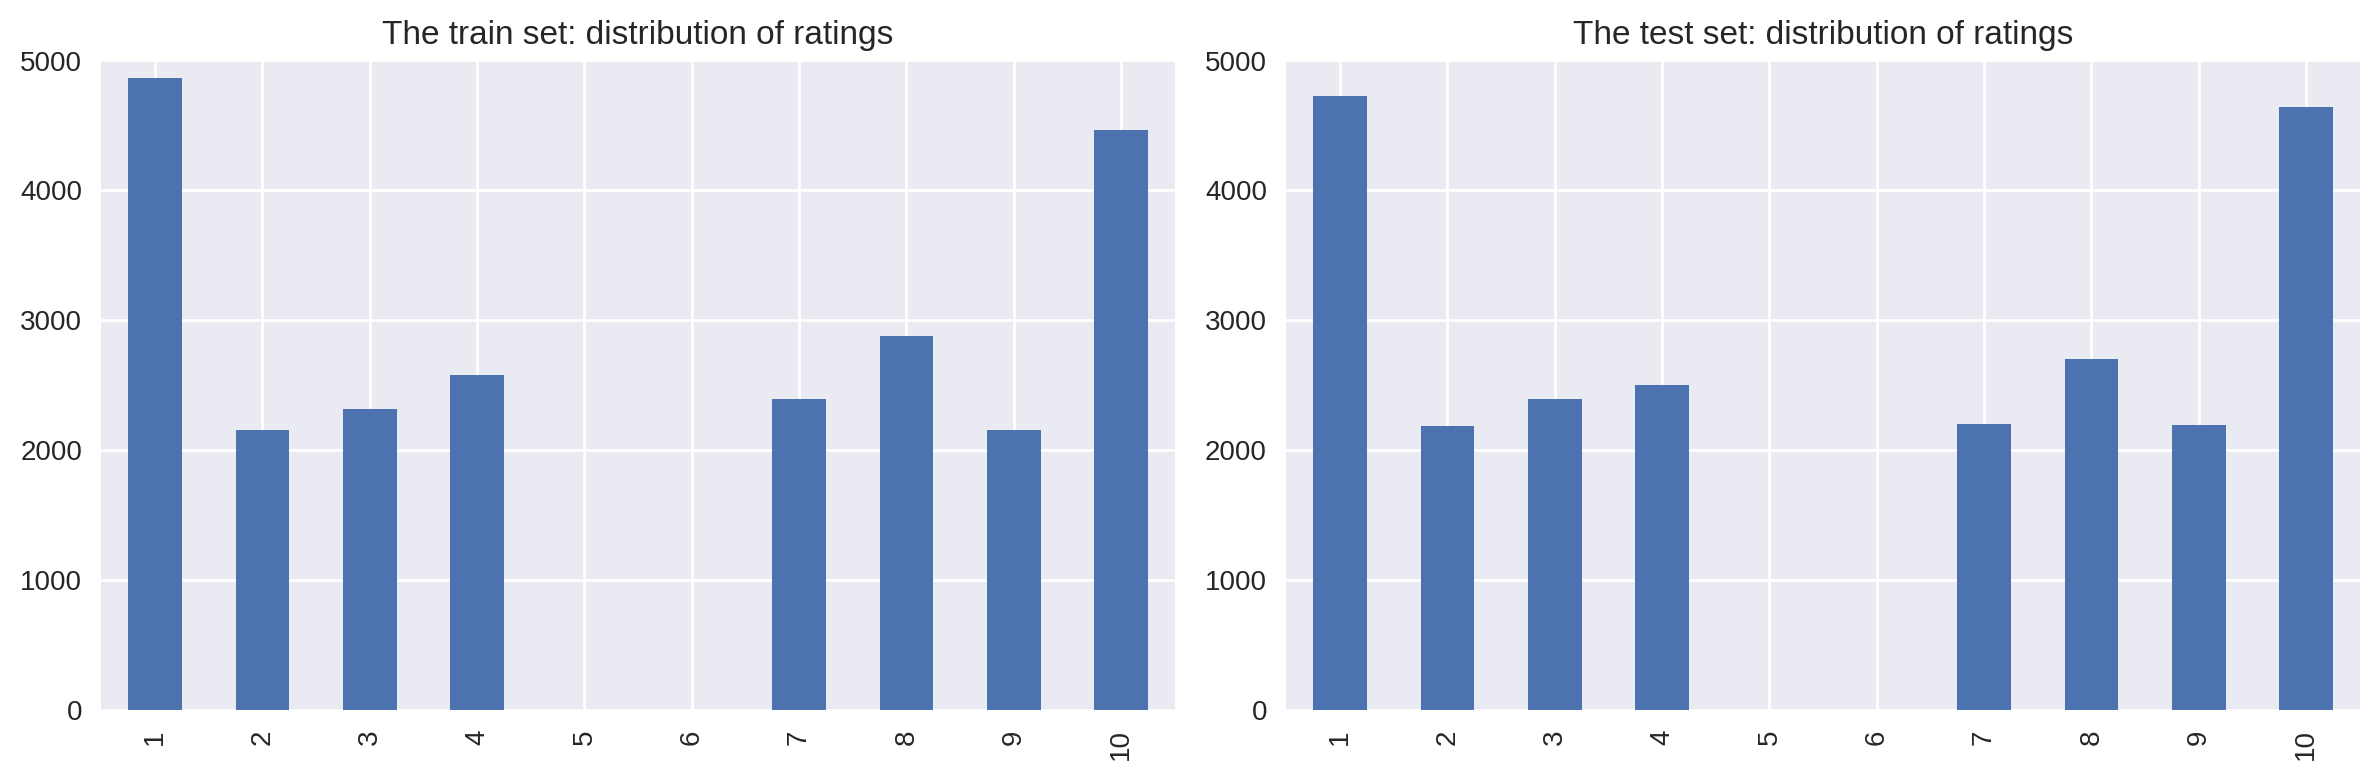

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


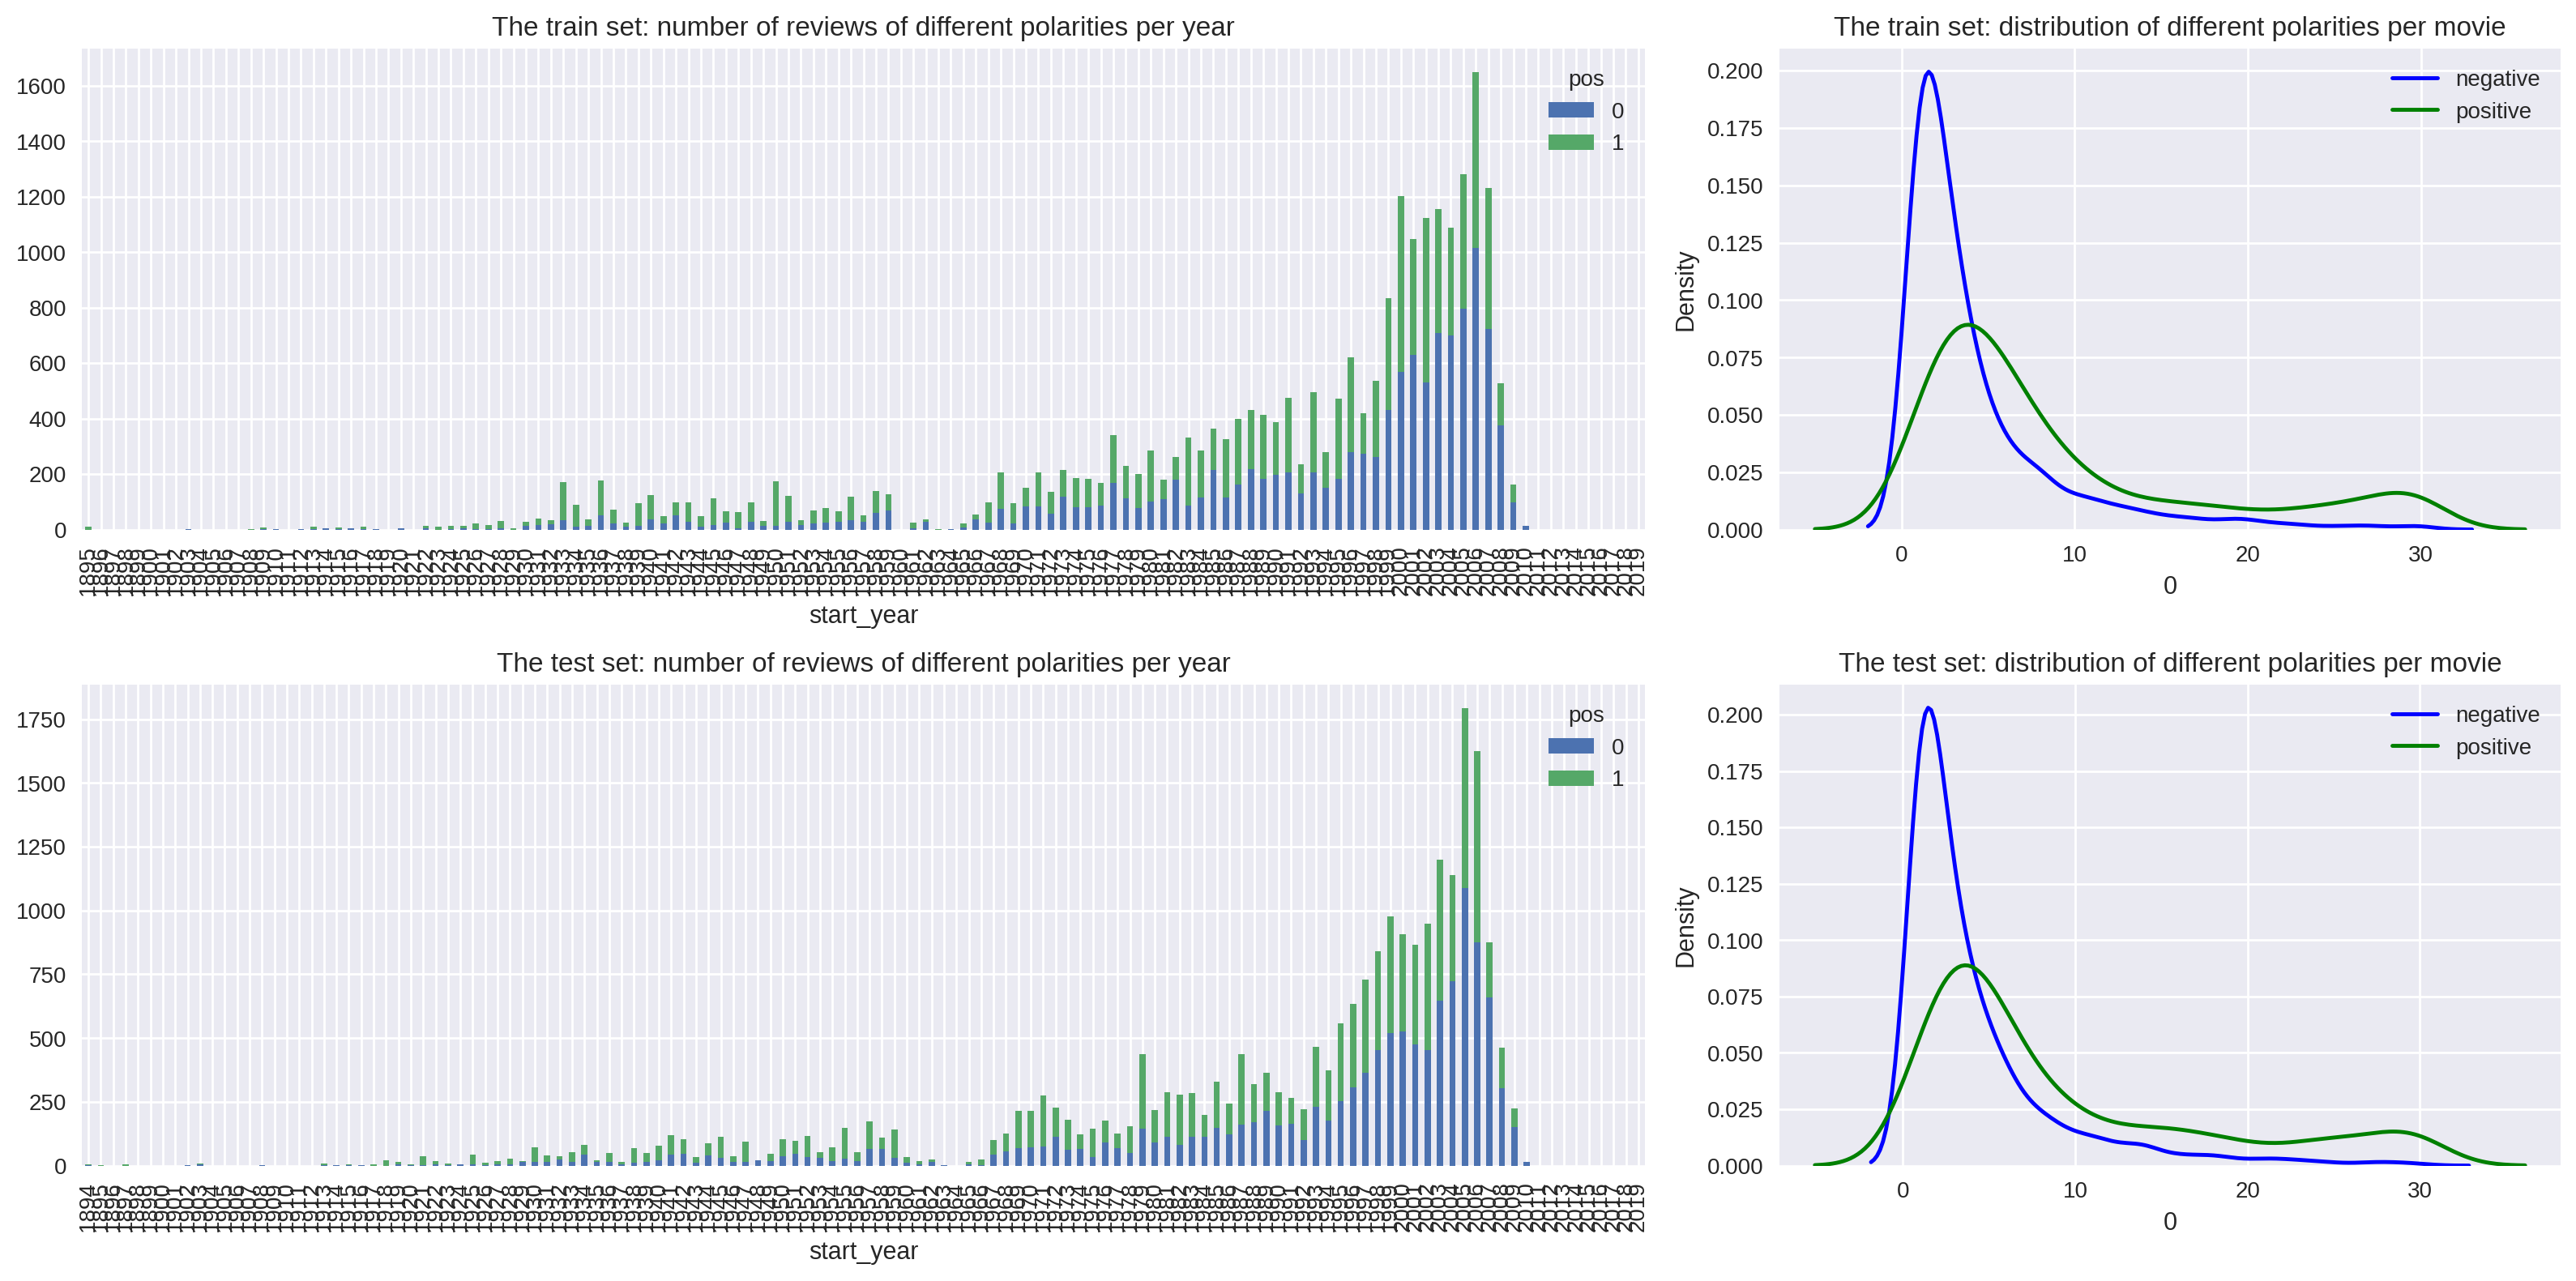

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Judging from the grapgs it appears movies with fewer reviews tend to have a larger amount of negative reviews.  That is likely due to movies that are not watched by many people tend to be poor movies.  The amount of movies and number of reviews per movie has grown significantly during the 2000s and 2010s.  It also appears a large portion of the movies only have 1 or a couple of reviews.  The reviews per movie has grown slightly over time as well.  It is also interesting that both sets of data do not have ratings that are a 5 or 6 they are all under or above the middle range.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import re

lemmatizer = WordNetLemmatizer()

corpus = df_reviews['review']

def clear_text(text):
    return  re.sub(r"\s+", ' ', re.sub(r"[^a-zA-Z'\s]", '', text).lower()).strip()

df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)


print(df_reviews[['review', 'review_norm']].head())

                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  the pakage implies that warren beatty and gold...  
1  how the hell did they get this made presenting...  
2  there is no real story the film seems more lik...  
3  um a serious film about troubled teens in sing...  
4  i'm totally agree with garryjohal from singapo...  


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [14]:
train_features = df_reviews.query('ds_part == "train"').copy()
test_features = df_reviews.query('ds_part == "test"').copy()

train_target = train_features['pos']
test_target = test_features['pos']

train_features.drop(columns=['pos'], inplace=True)
test_features.drop(columns=['pos'], inplace=True)

print(train_features.shape)
print(test_features.shape)
print()
print(train_features.info())
print(test_features.info())

(23796, 17)
(23535, 17)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23796 entries, 0 to 47257
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           23796 non-null  object 
 1   title_type       23796 non-null  object 
 2   primary_title    23796 non-null  object 
 3   original_title   23796 non-null  object 
 4   start_year       23796 non-null  int64  
 5   end_year         23796 non-null  object 
 6   runtime_minutes  23796 non-null  object 
 7   is_adult         23796 non-null  int64  
 8   genres           23796 non-null  object 
 9   average_rating   23796 non-null  float64
 10  votes            23796 non-null  Int64  
 11  review           23796 non-null  object 
 12  rating           23796 non-null  int64  
 13  sp               23796 non-null  object 
 14  ds_part          23796 non-null  object 
 15  idx              23796 non-null  int64  
 16  review_norm      23796 non-null  

## Working with models

### Model 0 - Constant

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

y_train = train_target
y_test = test_target

X_train = (train_features['review_norm'])
X_test = (test_features['review_norm'])

model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(train_features, train_target)
preds = model_0.predict(test_features)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


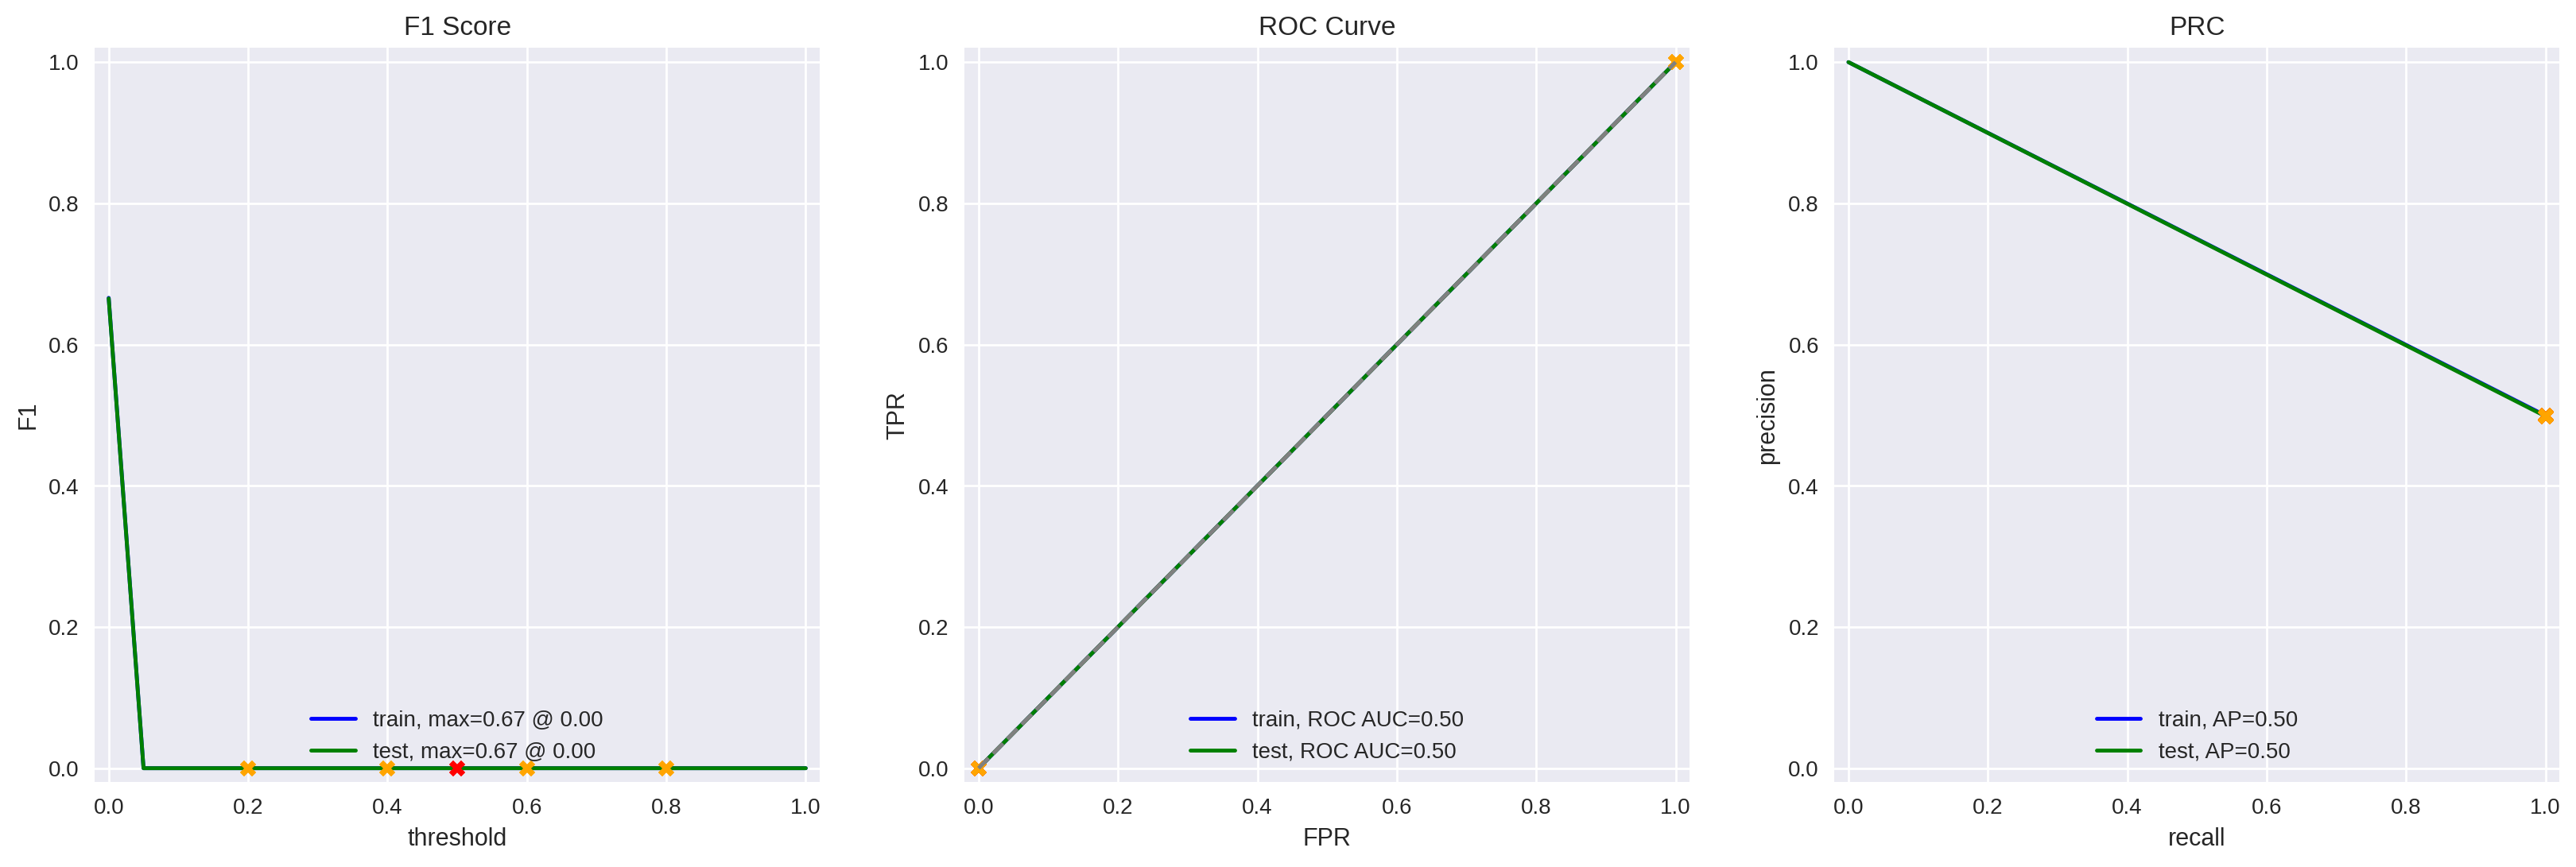

In [16]:
evaluate_model(
    model=model_0,
    train_features=X_train,
    train_target=y_train,
    test_features=X_test,
    test_target=y_test)


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [17]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [18]:
stop_words = set(stopwords.words('english'))

tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words, max_features=1000, ngram_range=(1,2), min_df=1, max_df=0.9)

X_train_tfidf = tfidf_vectorizer_1.fit_transform(train_features['review_norm'])
X_test_tfidf = tfidf_vectorizer_1.fit_transform(test_features['review_norm'])


model_1 = LogisticRegression(random_state=42, max_iter=1000)
model_1.fit(X_train_tfidf, y_train)
preds_1 = model_1.predict(X_test_tfidf)

          train  test
Accuracy   0.87  0.53
F1         0.87  0.49
APS        0.94  0.54
ROC AUC    0.95  0.55


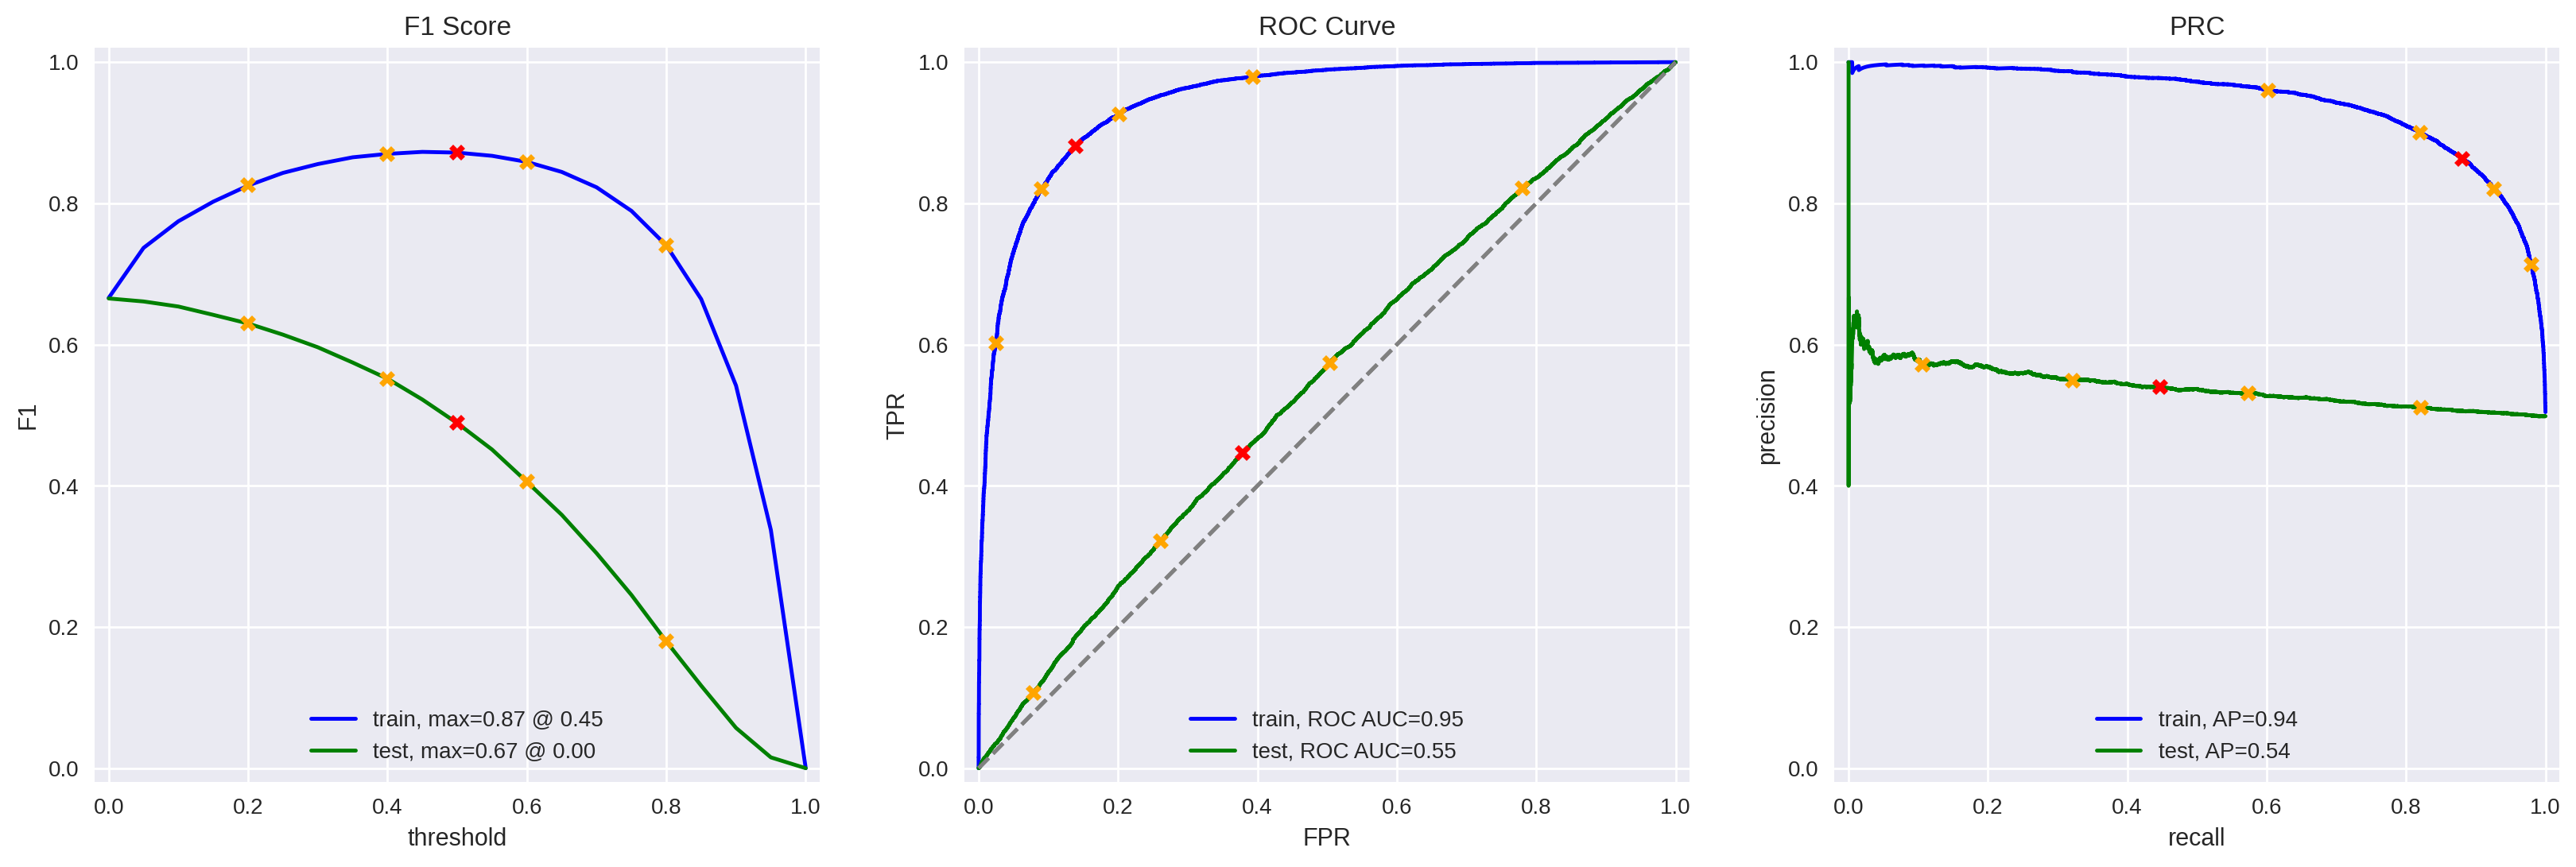

In [19]:
evaluate_model(
    model=model_1,
    train_features=X_train_tfidf,
    train_target=y_train,
    test_features=X_test_tfidf,
    test_target=y_test)

### Model 3 - spaCy, TF-IDF and LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def spacy_tokenizer(text):
    """
    Tokenize with spaCy, remove punctuation/spaces, 
    and return the lemma in lowercase. 
    Stop words are NOT removed here, so you can handle them elsewhere.
    """
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Keep everything except punctuation and whitespace
        if not token.is_punct and not token.is_space:
            tokens.append(token.lemma_.lower())
    return tokens

train_features['review_norm'] = train_features['review_norm'].apply(spacy_tokenizer)
test_features['review_norm'] = test_features['review_norm'].apply(spacy_tokenizer)

print(train_features['review_norm'])
print(test_features['review_norm'])

0        [the, pakage, imply, that, warren, beatty, and...
1        [how, the, hell, do, they, get, this, make, pr...
7        [this, true, story, of, carlson, 's, raider, b...
8        [should, have, be, title, balderdash, little, ...
9        [the, movie, gung, ho, the, story, of, carlson...
                               ...                        
47253    [o, my, gosh, just, give, i, a, minute, to, br...
47254    [i, can, not, tell, you, all, how, much, i, lo...
47255    [legend, of, zu, be, possibly, the, most, exci...
47256    [this, movie, be, well, do, on, so, many, leve...
47257    [as, a, history, nut, who, be, particularly, i...
Name: review_norm, Length: 23796, dtype: object
2        [there, be, no, real, story, the, film, seem, ...
3        [um, a, serious, film, about, troubled, teen, ...
4        [i, be, totally, agree, with, garryjohal, from...
5        [this, be, the, first, movie, i, 've, see, fro...
6        [yes, nonsingaporean, 's, can, not, see, what,...
        

In [26]:
train_features['review_norm'] = train_features['review_norm'].astype(str)
test_features['review_norm'] = test_features['review_norm'].astype(str)
print(train_features.info())
print(test_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23796 entries, 0 to 47257
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           23796 non-null  object 
 1   title_type       23796 non-null  object 
 2   primary_title    23796 non-null  object 
 3   original_title   23796 non-null  object 
 4   start_year       23796 non-null  int64  
 5   end_year         23796 non-null  object 
 6   runtime_minutes  23796 non-null  object 
 7   is_adult         23796 non-null  int64  
 8   genres           23796 non-null  object 
 9   average_rating   23796 non-null  float64
 10  votes            23796 non-null  Int64  
 11  review           23796 non-null  object 
 12  rating           23796 non-null  int64  
 13  sp               23796 non-null  object 
 14  ds_part          23796 non-null  object 
 15  idx              23796 non-null  int64  
 16  review_norm      23796 non-null  object 
dtypes: Int64(1),

In [27]:
tfidf_vectorizer_2 = TfidfVectorizer(lowercase=False, stop_words=stop_words, min_df=1, max_df=0.9, ngram_range=(1,2))

X_train_tfidf_2 = tfidf_vectorizer_2.fit_transform(train_features['review_norm'])
X_test_tfidf_2 = tfidf_vectorizer_2.transform(test_features['review_norm'])

model_2 = LogisticRegression(random_state=42, max_iter=100)
model_2.fit(X_train_tfidf_2, y_train)
preds_2 = model_2.predict(X_test_tfidf_2)


          train  test
Accuracy   0.96  0.88
F1         0.96  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


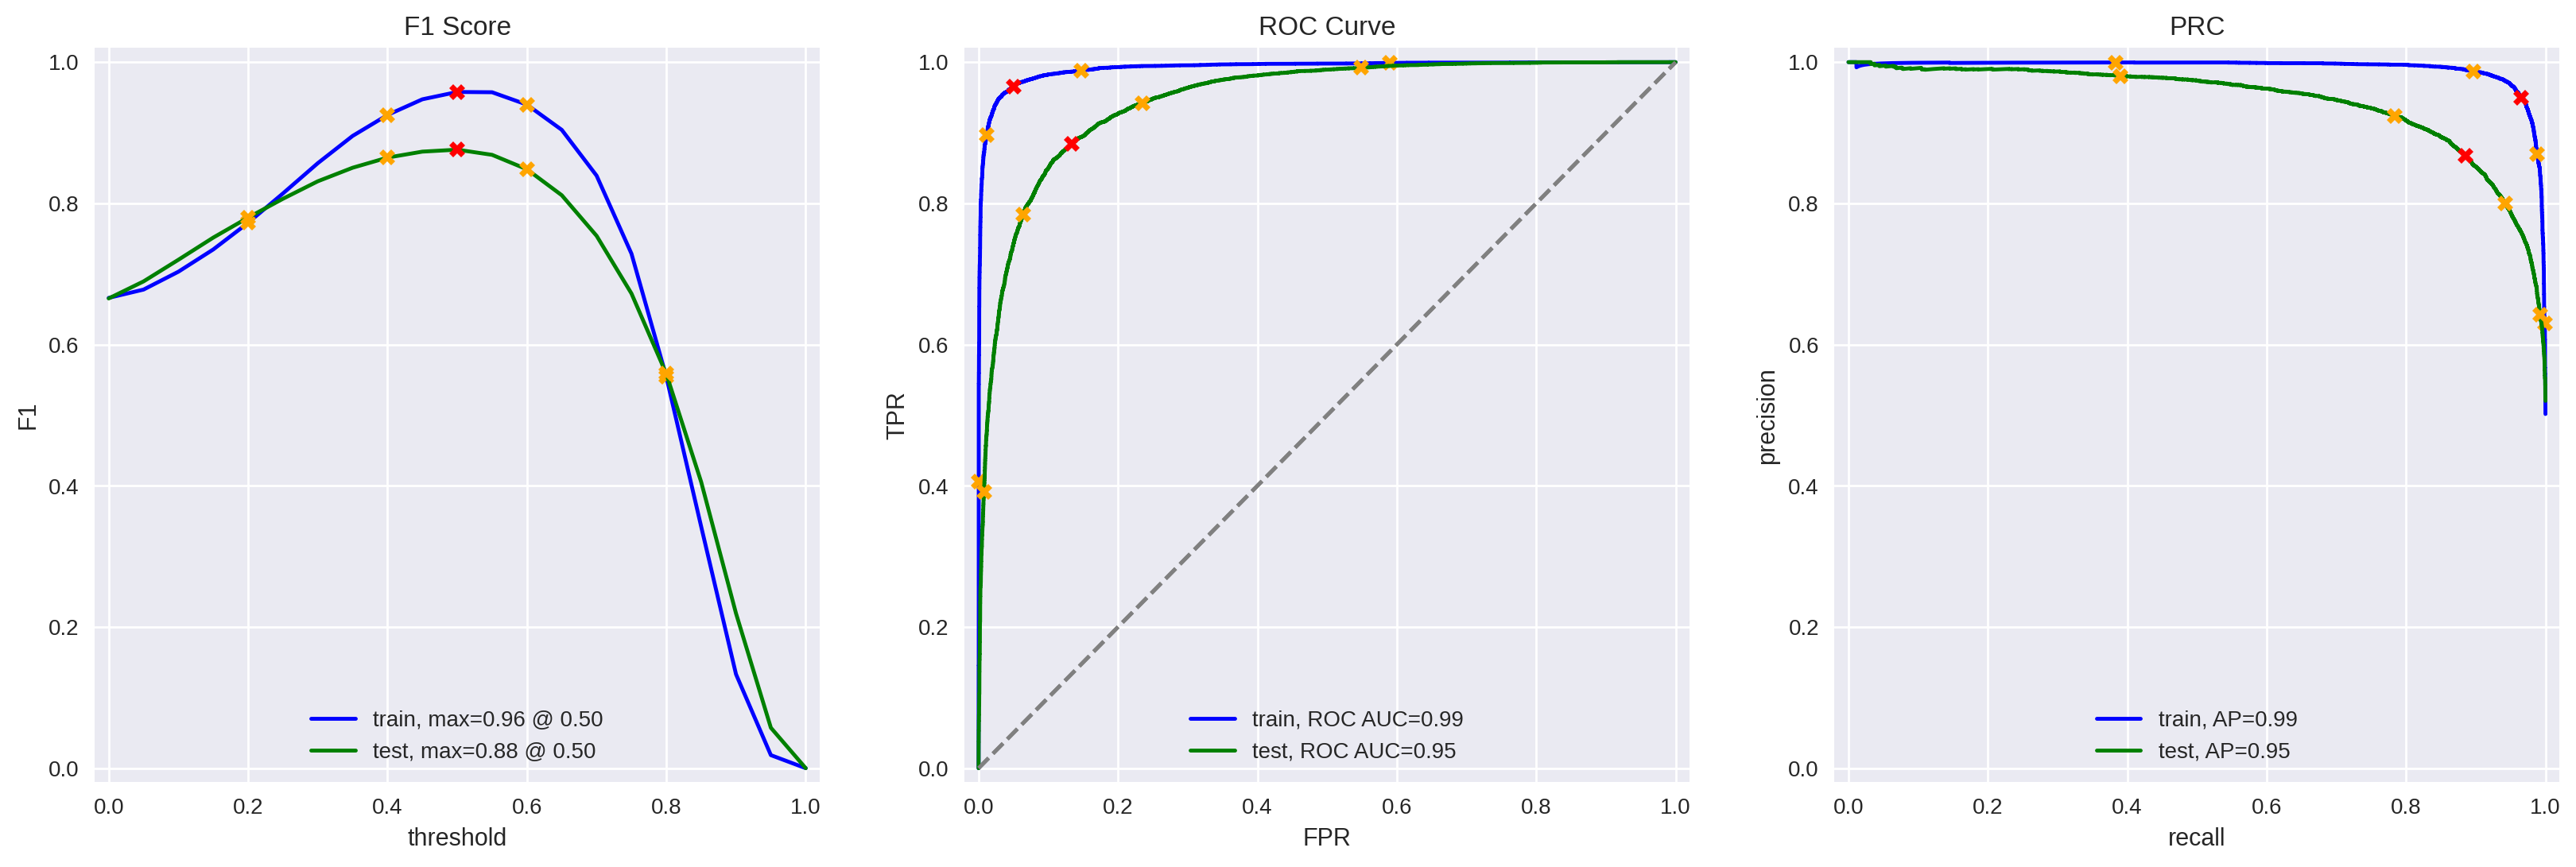

In [28]:
evaluate_model(
    model=model_2,
    train_features=X_train_tfidf_2,
    train_target=y_train,
    test_features=X_test_tfidf_2,
    test_target=y_test)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

In [30]:
model_3 = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1)

model_3.fit(X_train_tfidf_2, y_train)
preds_3 = model_3.predict(X_test_tfidf_2)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


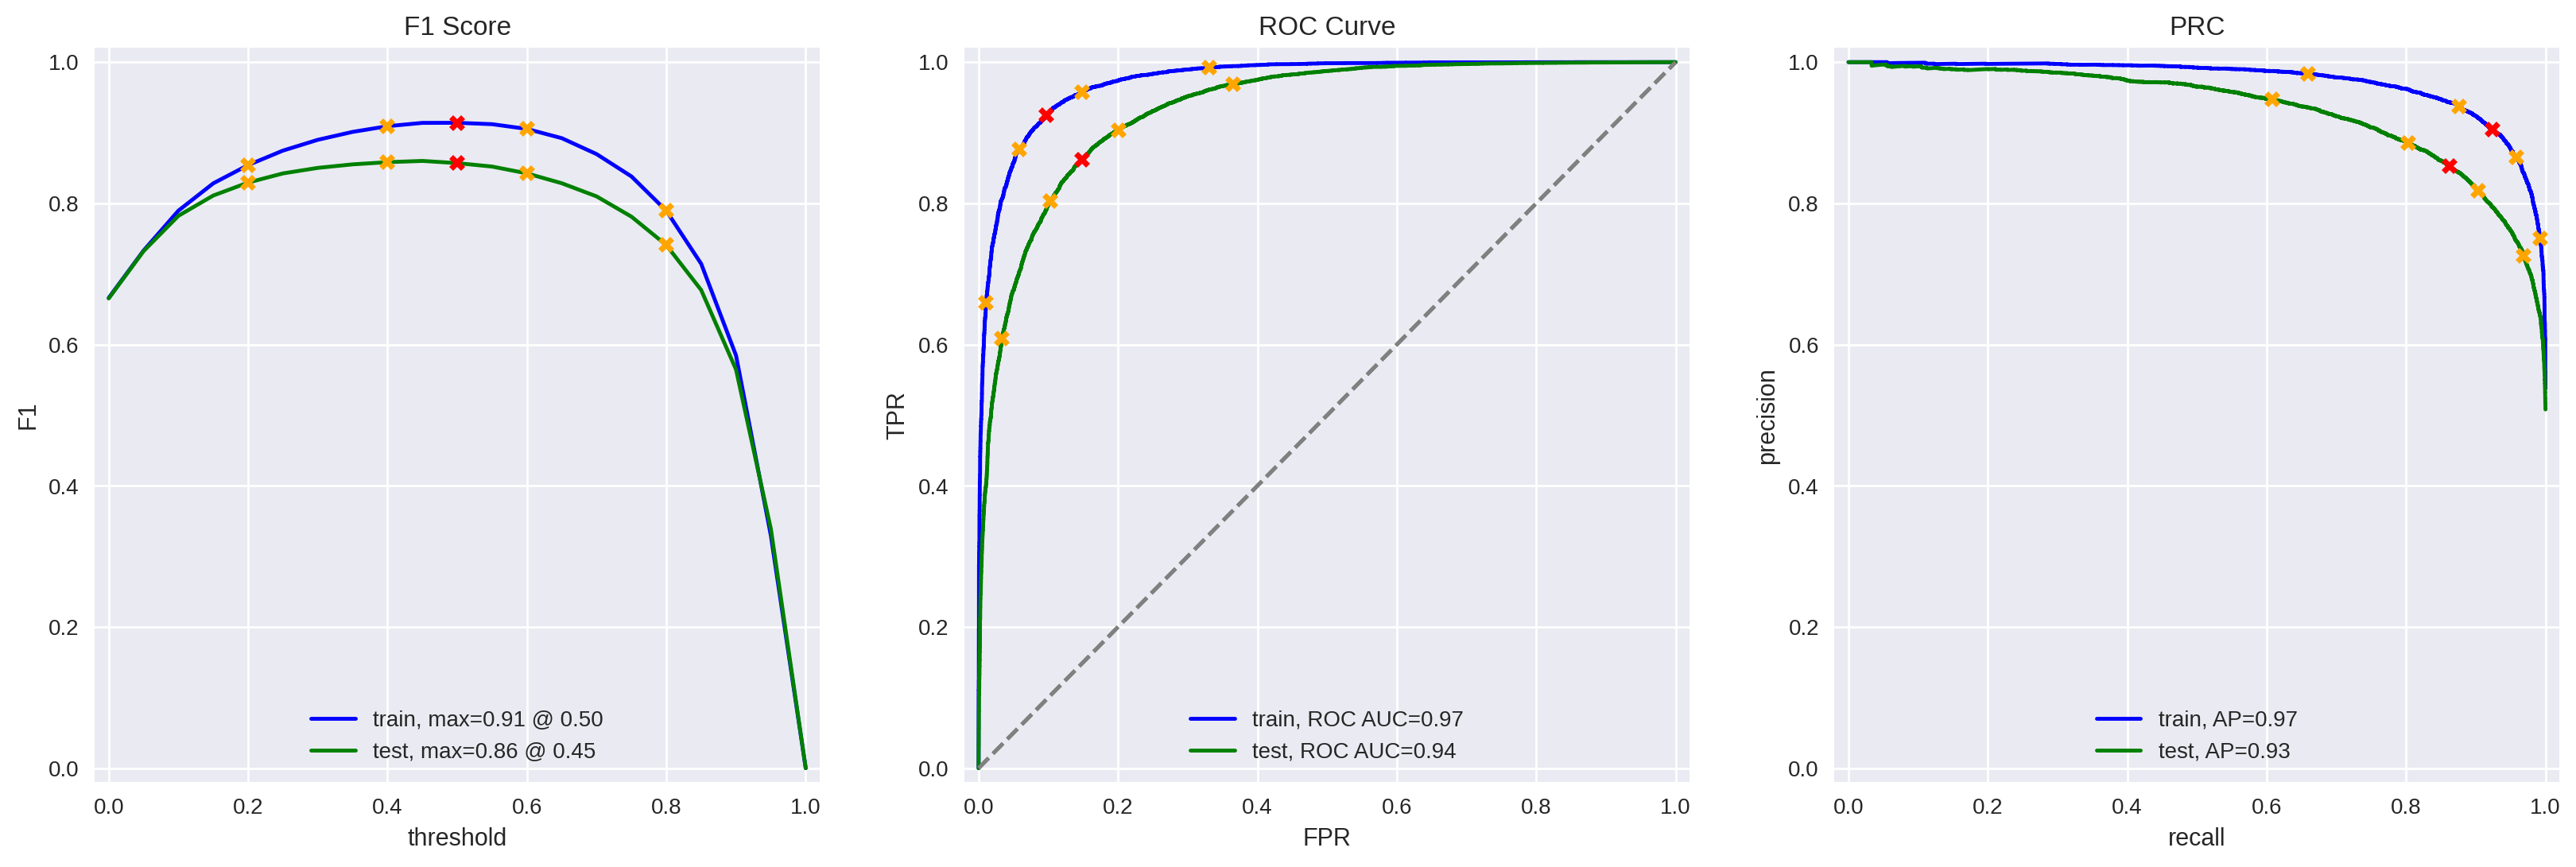

In [31]:
evaluate_model(
    model=model_3,
    train_features=X_train_tfidf_2,
    train_target=y_train,
    test_features=X_test_tfidf_2,
    test_target=y_test)

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

## My Reviews

In [34]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
# <put here the same normalization logic as for the main dataset>

print(my_reviews.head(5))

                                              review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   

                                         review_norm  
0      i did not simply like it not my kind of movie  
1  well i was bored and felt asleep in the middle...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn't expect the reboot to be so good write...  


### Model 1

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.03:  well i was bored and felt asleep in the middle of the movie
0.14:  i was really fascinated with the movie
0.88:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.53:  i didn't expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.71:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 2

In [37]:
my_reviews['review_norm'] = my_reviews['review_norm'].apply(spacy_tokenizer)
my_reviews['review_norm'] = my_reviews['review_norm'].astype(str) 

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(my_reviews['review_norm']))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.29:  ['i', 'do', 'not', 'simply', 'like', 'it', 'not', 'my', 'kind', 'of', 'movie']
0.31:  ['well', 'i', 'be', 'bored', 'and', 'feel', 'asleep', 'in', 'the', 'middle', 'of', 'the', 'movie']
0.46:  ['i', 'be', 'really', 'fascinated', 'with', 'the', 'movie']
0.16:  ['even', 'the', 'actor', 'look', 'really', 'old', 'and', 'disintereste', 'and', 'they', 'get', 'pay'
0.31:  ['i', 'do', 'not', 'expect', 'the', 'reboot', 'to', 'be', 'so', 'good', 'writer', 'really', 'care', 
0.39:  ['the', 'movie', 'have', 'its', 'upside', 'and', 'downside', 'but', 'i', 'feel', 'like', 'overall', 
0.16:  ['what', 'a', 'rotten', 'attempt', 'at', 'a', 'comedy', 'not', 'a', 'single', 'joke', 'land', 'every
0.85:  ['launch', 'on', 'netflix', 'be', 'a', 'brave', 'move', 'i', 'really', 'appreciate', 'be', 'able', '


### Model 3

In [38]:
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_2.transform(my_reviews['review_norm']))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  ['i', 'do', 'not', 'simply', 'like', 'it', 'not', 'my', 'kind', 'of', 'movie']
0.40:  ['well', 'i', 'be', 'bored', 'and', 'feel', 'asleep', 'in', 'the', 'middle', 'of', 'the', 'movie']
0.62:  ['i', 'be', 'really', 'fascinated', 'with', 'the', 'movie']
0.33:  ['even', 'the', 'actor', 'look', 'really', 'old', 'and', 'disintereste', 'and', 'they', 'get', 'pay'
0.65:  ['i', 'do', 'not', 'expect', 'the', 'reboot', 'to', 'be', 'so', 'good', 'writer', 'really', 'care', 
0.70:  ['the', 'movie', 'have', 'its', 'upside', 'and', 'downside', 'but', 'i', 'feel', 'like', 'overall', 
0.27:  ['what', 'a', 'rotten', 'attempt', 'at', 'a', 'comedy', 'not', 'a', 'single', 'joke', 'land', 'every
0.81:  ['launch', 'on', 'netflix', 'be', 'a', 'brave', 'move', 'i', 'really', 'appreciate', 'be', 'able', '


### Model 9

          train  test
Accuracy   0.87  0.53
F1         0.87  0.49
APS        0.94  0.54
ROC AUC    0.95  0.55
          train  test
Accuracy   0.96  0.88
F1         0.96  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95
          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


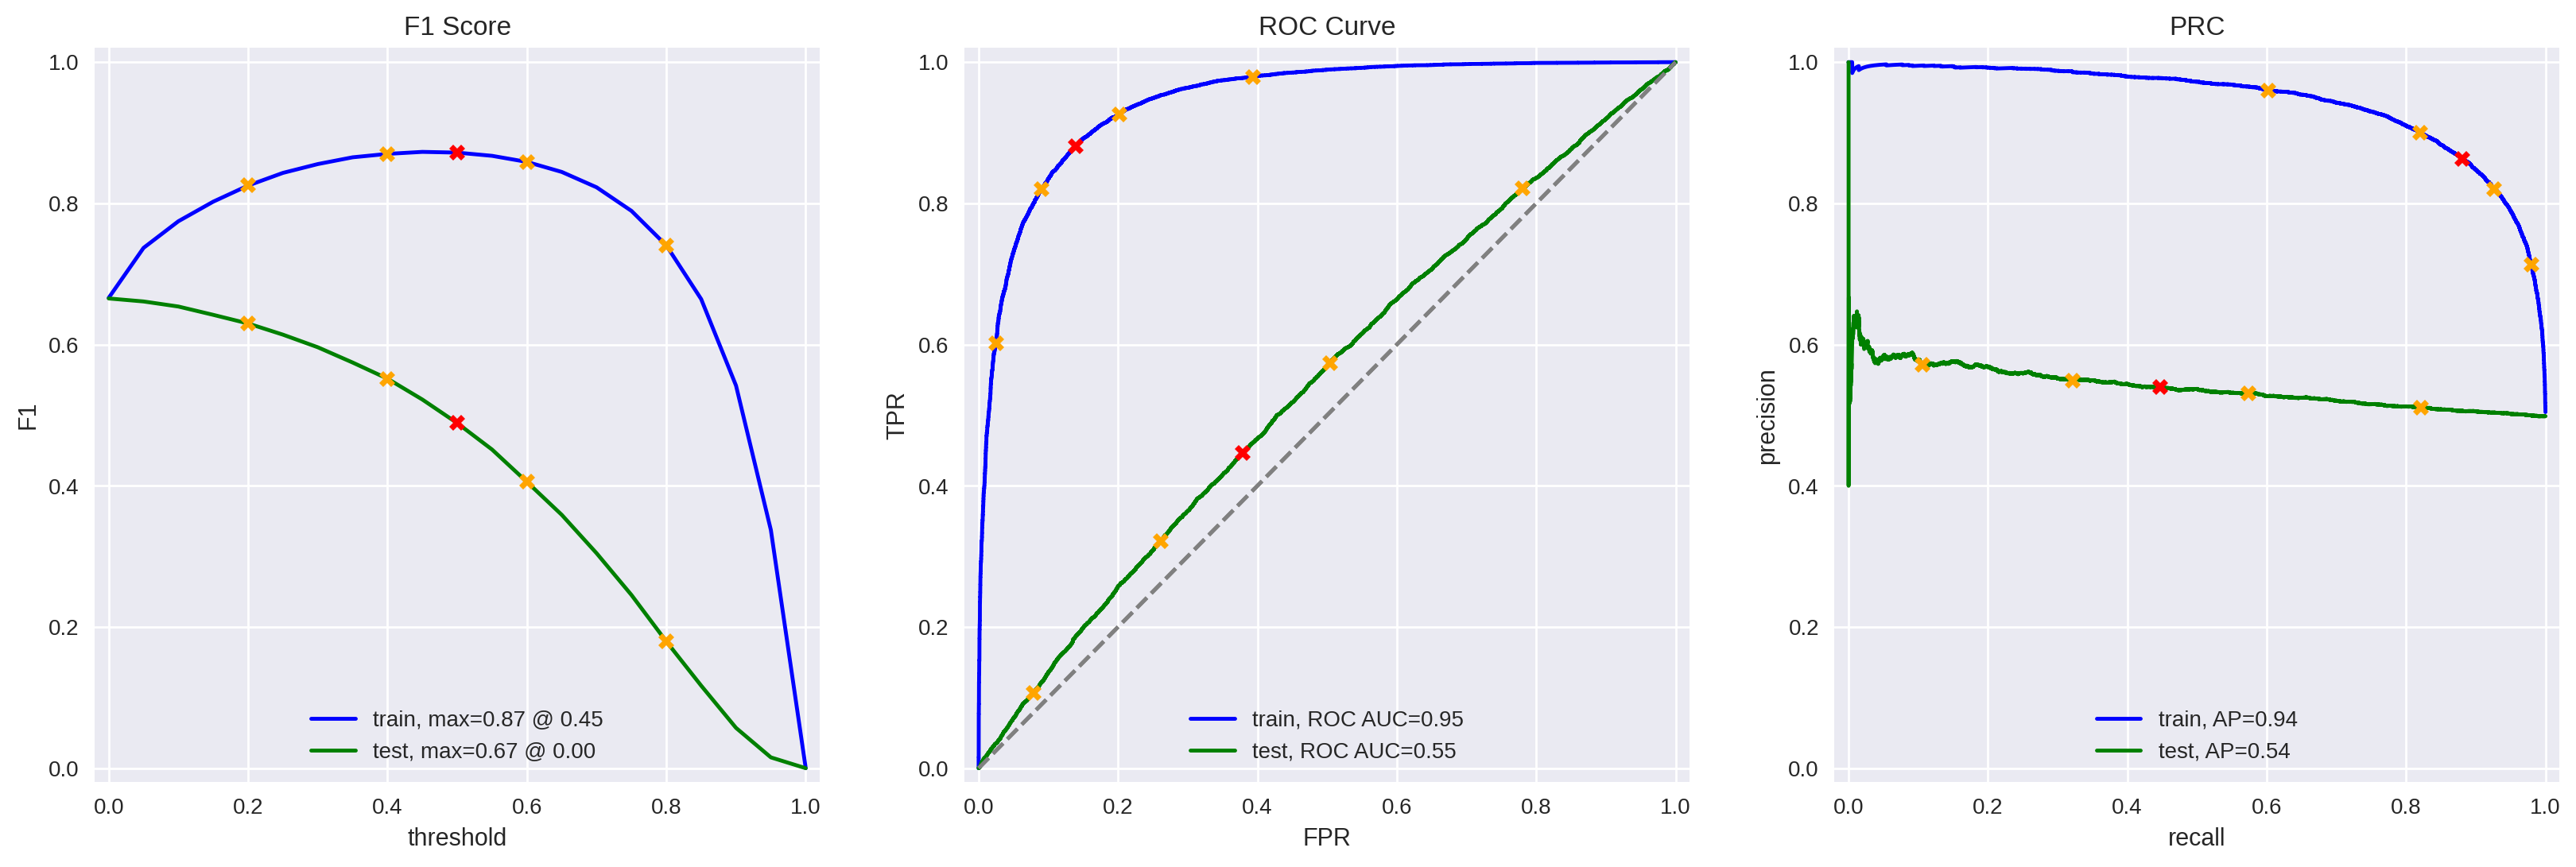

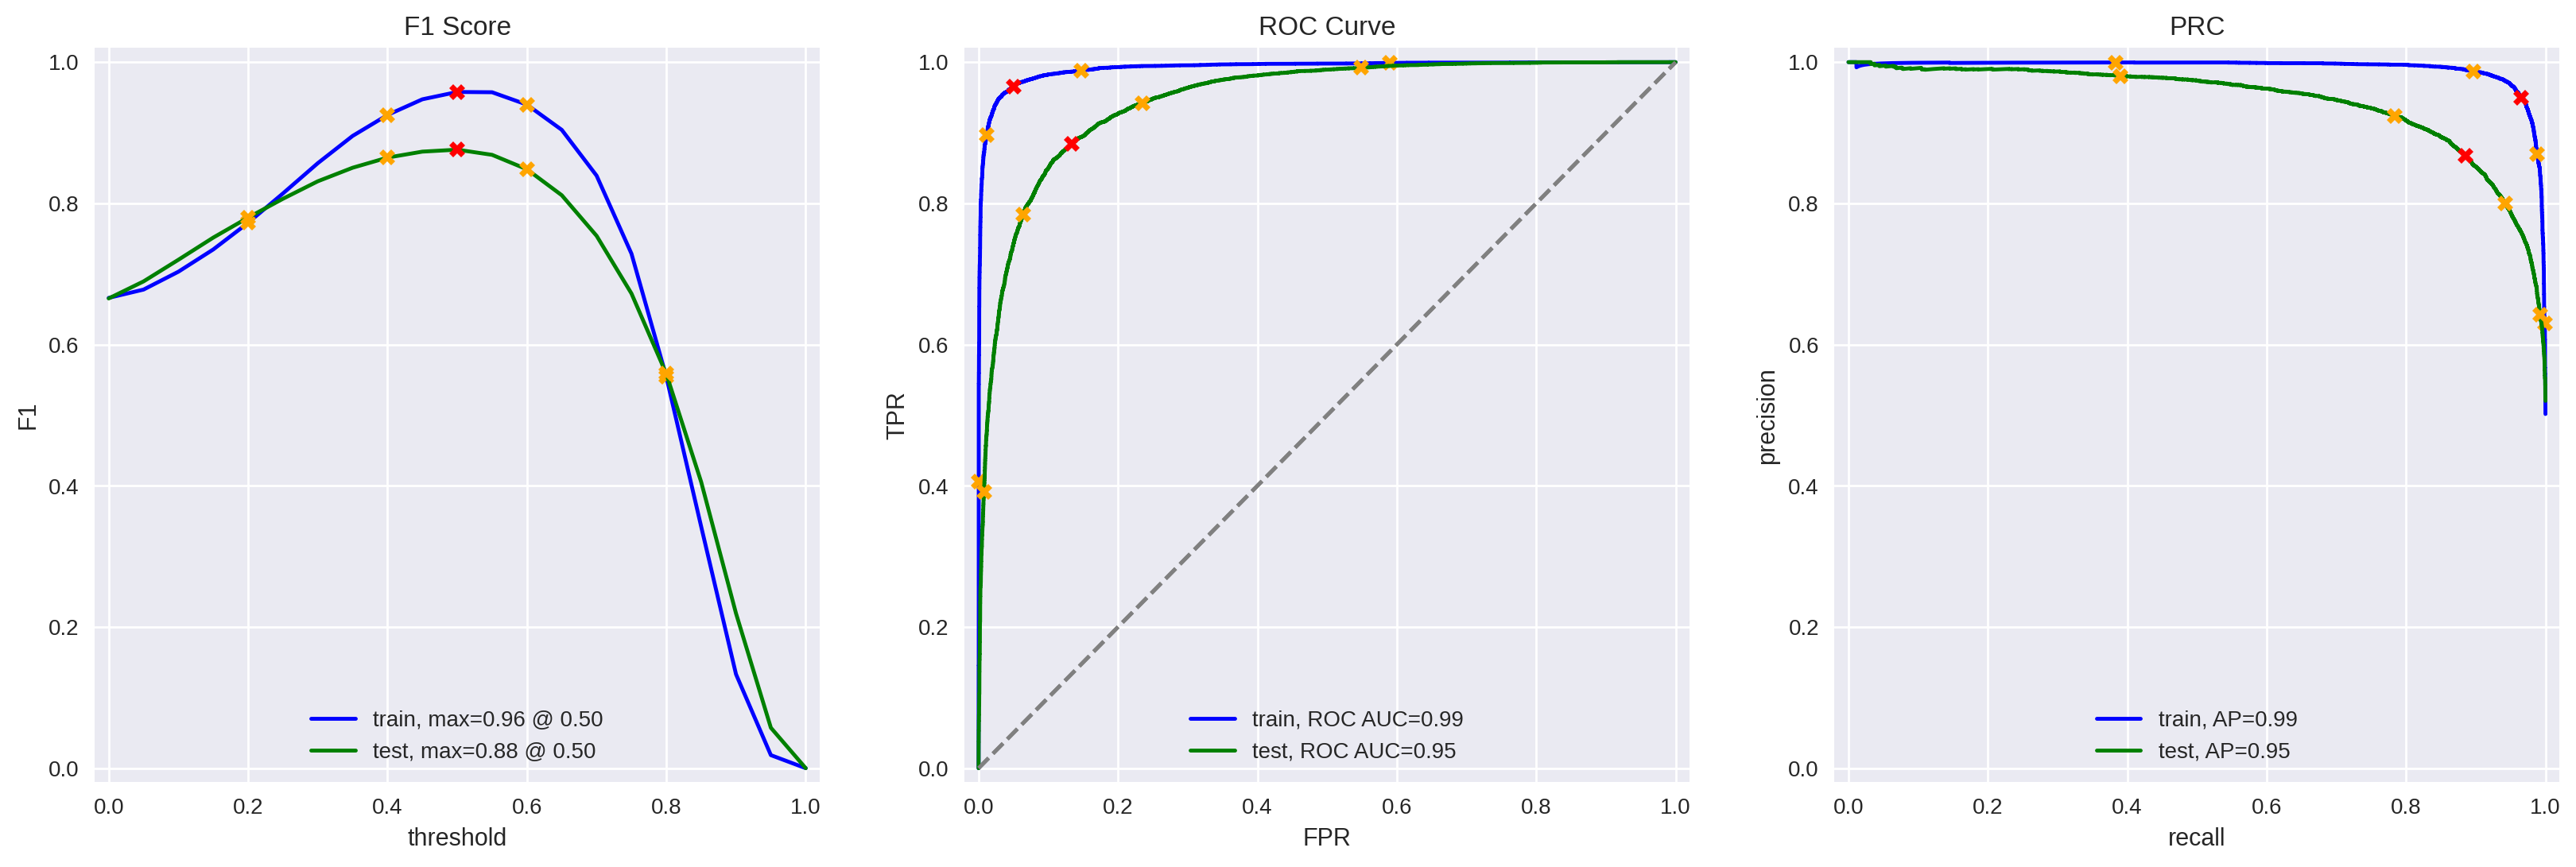

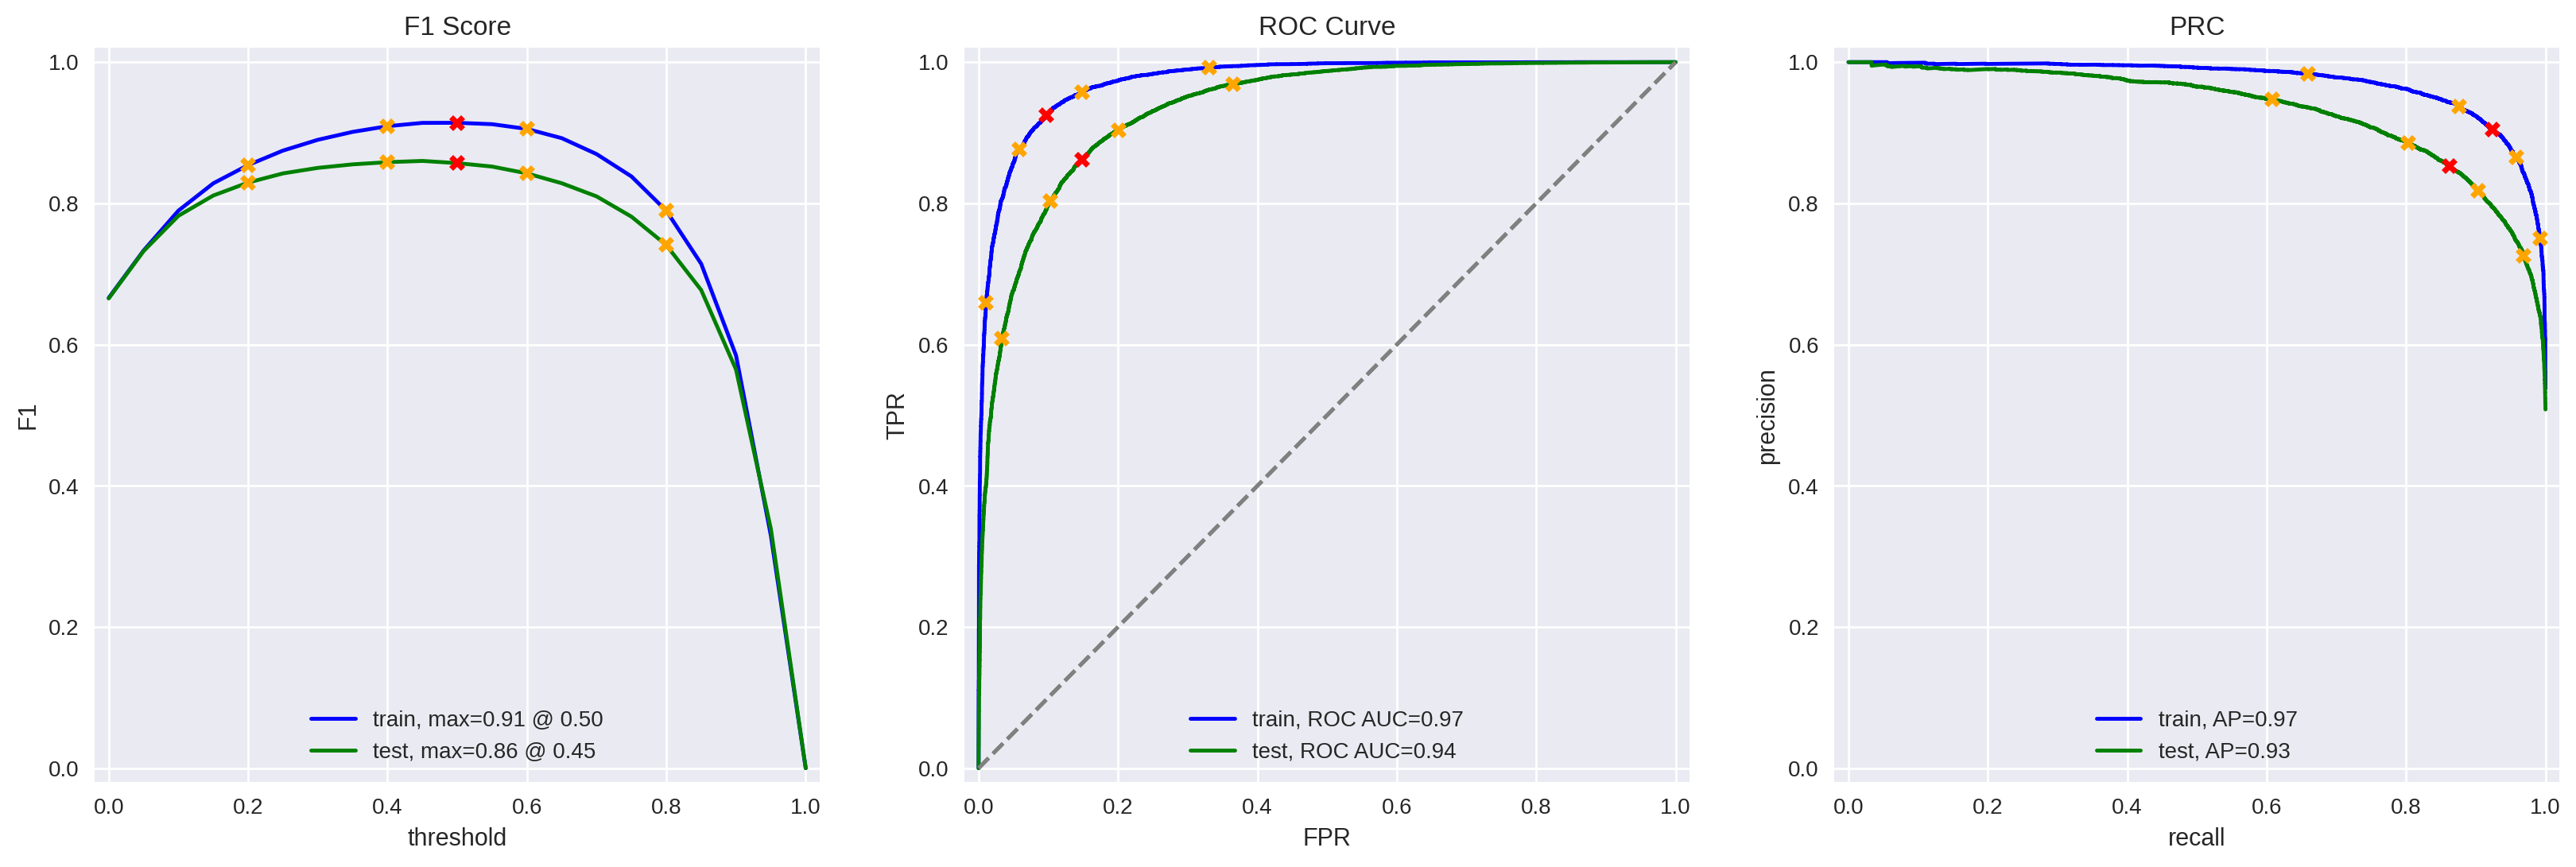

In [39]:
evaluate_model(
    model=model_1,
    train_features=X_train_tfidf,
    train_target=y_train,
    test_features=X_test_tfidf,
    test_target=y_test)

evaluate_model(
    model=model_2,
    train_features=X_train_tfidf_2,
    train_target=y_train,
    test_features=X_test_tfidf_2,
    test_target=y_test)

evaluate_model(
    model=model_3,
    train_features=X_train_tfidf_2,
    train_target=y_train,
    test_features=X_test_tfidf_2,
    test_target=y_test)

## Conclusions

Based off ou analysis the model that performed the best according to our evaluation tests of Accuracy, F1, APS and ROC AUC was the spaCy, TF-IDF and Logisitic Regression Model.  It had the highest scores on the test set for every score that we ran.  The Accuracy and F1 score was a 0.88 and the APS and ROC AUC scores were a 0.95.  The next closest was the spaCy, TF-IDF LGBM model with an accuracy and F1 score of 0.86 and an ROC AUC score of 0.94.  It performed only slightly worse than the logistic regression.  The logistic regression model without spaCy performed the worst by far.  It did not perform over 0.55 on any of the variables we tested for.  

# Checklist

- [x]  Notebook was opened
- [X]  The text data is loaded and pre-processed for vectorization
- [X]  The text data is transformed to vectors
- [X]  Models are trained and tested
- [X]  The metric's threshold is reached
- [X]  All the code cells are arranged in the order of their execution
- [X]  All the code cells can be executed without errors
- [X]  There are conclusions